In [1]:
import os
import torch
import numpy as np
import pandas as pd
import torch.nn as nn
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import sys
sys.path.insert(1, '/home/kseuro/Kai/deeplearnphysics/pytorch/particle_generator/')

# My stuff
import ae
import conv_ae
import utils
from dataloader import LArCV_loader

In [3]:
# Set the GPU (GPU 1 is the best option)
device = torch.device(2)

In [4]:
# Set the root path of the AutoEncoder experiments folder
exp_root = "/media/hdd1/kai/particle_generator/experiments/"

In [5]:
# Set the model type folder (either MLP or Conv model)
model_folder = "larcv_ae/" + "conv_ae/"

In [6]:
# Update the exp_root
exp_root += model_folder

## Get the names of all the experiments in the exp_root folder

In [7]:
exp_paths = []
for path in os.listdir(exp_root):
    exp_paths.append(os.path.join(exp_root, path))

print("-"*60)
for i in range(len(exp_paths)):
    print("\n{}:".format(str(i)), exp_paths[i], '\n')
    print("-"*60)

------------------------------------------------------------

0: /media/hdd1/kai/particle_generator/experiments/larcv_ae/conv_ae/conv_ae_64_4-2-2 

------------------------------------------------------------

1: /media/hdd1/kai/particle_generator/experiments/larcv_ae/conv_ae/conv_ae_64_1000-epochs 

------------------------------------------------------------

2: /media/hdd1/kai/particle_generator/experiments/larcv_ae/conv_ae/conv_ae_128_32-8-8-code-dim 

------------------------------------------------------------


In [8]:
# Set the dir of the particular experiment to be deployed
exp_dir = exp_paths[0]

In [9]:
# Create the full path to the experiment
exp_path = os.path.join(exp_root, exp_dir) + "/"
print("Experiment path set as: \n{}".format(exp_path))

Experiment path set as: 
/media/hdd1/kai/particle_generator/experiments/larcv_ae/conv_ae/conv_ae_64_4-2-2/


In [10]:
# Load the config csv as a dict
config_csv = exp_path + "config.csv"
config_df = pd.read_csv(config_csv, delimiter = ",")

In [11]:
# Get the model architecture from config df
n_layers = int(config_df[config_df['Unnamed: 0'].str.contains("n_layers")==True]['0'].values.item())
l_dim    = int(config_df[config_df['Unnamed: 0'].str.contains("l_dim")==True]['0'].values.item())
im_size  = int(config_df[config_df['Unnamed: 0'].str.contains("dataset")==True]['0'].values.item())**2
depth    = int(config_df[config_df['Unnamed: 0'].str.contains("depth")==True]['0'].values.item())
im_dim   = int(np.sqrt(im_size))

In [12]:
# Path to model weights
weights_dir = "weights/"

## Path to the test data

In [13]:
test_data = "/media/hdd1/kai/particle_generator/larcv_data/test/larcv_png_{}/".format(im_dim)
num_test_ex = sum( [len(examples) for _, _, examples in os.walk(test_data)] )
print("{} test data will be loaded from: \n{}".format(num_test_ex, test_data))

10000 test data will be loaded from: 
/media/hdd1/kai/particle_generator/larcv_data/test/larcv_png_64/


## Path to reference training data

In [14]:
# Path to the reference training data
train_data = "/media/hdd1/kai/particle_generator/larcv_data/train/train_reference/larcv_png_{}/".format(im_dim)
num_train_ex = sum( [len(examples) for _, _, examples in os.walk(train_data)] )
print("{} reference training data will be loaded from: \n{}".format(num_train_ex, train_data))

10000 reference training data will be loaded from: 
/media/hdd1/kai/particle_generator/larcv_data/train/train_reference/larcv_png_64/


## Set up the torch dataloader

In [15]:
loader_kwargs = {'num_workers' : 2, 'batch_size': 1, 'shuffle': True}
transforms = transforms.Compose([transforms.ToTensor(), transforms.Normalize([0.5],[0.5])])
test_dataset    = LArCV_loader(root = test_data,  transforms = transforms)
train_dataset   = LArCV_loader(root = train_data, transforms = transforms) 

Image conversion flag is: L
Images will be loaded from subfolder of: /media/hdd1/kai/particle_generator/larcv_data/test/larcv_png_64/
Image conversion flag is: L
Images will be loaded from subfolder of: /media/hdd1/kai/particle_generator/larcv_data/train/train_reference/larcv_png_64/


In [16]:
test_loader = DataLoader(test_dataset, **loader_kwargs)
train_loader = DataLoader(train_dataset, **loader_kwargs)

## Setup AE layers

In [17]:
# Set up AE layer sizes
if 'mlp' in exp_path:
    base = [256] 

    # Compute encoder sizes
    sizes = lambda: [ (yield 2**i) for i in range(n_layers) ]
    enc_sizes = base * n_layers
    enc_sizes = [a*b for a,b in zip(enc_sizes, [*sizes()])][::-1]

    # Update kwarg dicts
    # Decoder is the reverse of the encoder
    ae_kwargs = {'enc_sizes' : enc_sizes, 'l_dim' : l_dim, 'im_size' : im_size, 'dec_sizes' : enc_sizes[::-1]}
else:
    # Compute the depth of the feature maps, based on the number of
    # specified layers. If depth is not divisibe by 4, warn
    depth   = [depth] * n_layers
    divisor = lambda: [ (yield 2**i) for i in range(n_layers) ]
    depth   = [a//b for a,b in zip(depth, [*divisor()])][::-1]
        
    # Update kwarg dicts
    # Decoder is the reverse of the encoder
    ae_kwargs = {'enc_depth':[1]+depth+[l_dim], 'dec_depth':[l_dim]+depth[::-1]+[1],'l_dim':l_dim} 

## Track MSE results in list

## !!! DO NOT RE-RUN THIS CELL !!! ##

In [29]:
MSE_results = []

## !!! DO NOT RE-RUN THIS CELL !!! ##

## Setup the model loss function

In [19]:
loss_fn = nn.MSELoss().to(device)

## Load model checkpoint

In [20]:
# Get checkpoint name(s)
checkpoint_path  = exp_path + weights_dir
checkpoint_names = []
for file in os.listdir(checkpoint_path):
    checkpoint_names.append(os.path.join(checkpoint_path, file))

In [21]:
checkpoint_name_labels = []

In [22]:
print("-"*60)
for i in range(len(checkpoint_names)):
    name = checkpoint_names[i].split('/')[-1]
    checkpoint_name_labels.append(name)
    print("\n{}:".format(str(i)), name, '\n')
    print("-"*60)

------------------------------------------------------------

0: best_conv_ae_ep_650.tar 

------------------------------------------------------------

1: best_conv_ae_ep_600.tar 

------------------------------------------------------------

2: best_conv_ae_ep_999.tar 

------------------------------------------------------------

3: best_conv_ae_ep_700.tar 

------------------------------------------------------------

4: best_conv_ae_ep_850.tar 

------------------------------------------------------------

5: best_conv_ae_ep_900.tar 

------------------------------------------------------------

6: best_conv_ae_ep_950.tar 

------------------------------------------------------------

7: best_conv_ae_ep_750.tar 

------------------------------------------------------------

8: best_conv_ae_ep_800.tar 

------------------------------------------------------------


In [23]:
index = 1
current_checkpoint = checkpoint_names[index]
current_checkpoint_label = checkpoint_name_labels[index]

In [24]:
# Load the model checkpoint
# Keys: ['state_dict', 'epoch', 'optimizer']
checkpoint = torch.load(current_checkpoint)

In [25]:
# Set up model on GPU
if 'mlp' in exp_path:
    model = ae.AutoEncoder(**ae_kwargs).to(device)
else:
    model = conv_ae.ConvAutoEncoder(**ae_kwargs).to(device)

In [26]:
# Load the model's state dictionary
# Note: The IncompatibleKeys(missing_keys=[], unexpected_keys=[]) message indicates that
#       there were no problems in loading the state dictionary. Bit confusing...
model.load_state_dict(checkpoint['state_dict'])

<All keys matched successfully>

In [27]:
# Put the model in training mode
model.train()

ConvAutoEncoder(
  (encoder): ConvEncoder(
    (conv_blocks): Sequential(
      (0): Sequential(
        (0): Conv2d(1, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): LeakyReLU(negative_slope=0.2)
        (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      )
      (1): Sequential(
        (0): Conv2d(4, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): LeakyReLU(negative_slope=0.2)
        (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      )
      (2): Sequential(
        (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): LeakyReLU(negative_slope=0.2)
        (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      )
      (3): Sequential(
        (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): LeakyReLU(negative_slope=0.2)
        (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dila

## Loop over the test data and record the losses for the checkpoint

In [30]:
test_losses = []

In [31]:
for idx, image in enumerate(test_loader):
    
    # Flatten image into a vector -- if mlp
    if 'mlp' in exp_path:
        image = image.view(loader_kwargs['batch_size'], -1).to(device)
    else:
        image = image.to(device)
    
    # Forward pass
    output = model(image)
    
    # Get the loss value for the batch
    loss = loss_fn(output, image)
    
    # Append loss value
    test_losses.append(float(loss.item()))

In [32]:
print(len(test_losses))

10000


## Compute the average loss over segments of the test_loss results

In [33]:
avg_test_loss = []

In [34]:
step_size = 100
for step in range(0, len(test_losses), step_size):
    avg_test_loss.append( np.mean(test_losses[step:step+step_size]) )

## Loop over the training data and record the average loss for the checkpoint
- Here, we only loop over the REFERENCE training examples

In [35]:
train_losses = []

In [36]:
for idx, image in enumerate(train_loader):    

    # Flatten image into a vector
    if 'mlp' in exp_path:
        image = image.view(loader_kwargs['batch_size'], -1).to(device)
    else:
        image = image.to(device)
    
    # Forward pass
    output = model(image)
    
    # Get the loss value for the batch
    loss = loss_fn(output, image)
    
    # Append loss value
    train_losses.append(float(loss.item()))

In [37]:
avg_train_loss = []

In [38]:
step_size = 100
for step in range(0, len(train_losses), step_size):
    avg_train_loss.append( np.mean(train_losses[step:step+step_size]) )

## Append the average test and train losses for checkpoint to MSE_results list

In [39]:
eval_ = (current_checkpoint_label, avg_test_loss, avg_train_loss)
MSE_results.append( eval_ )

In [49]:
print(MSE_results[0][0], min(MSE_results[0][1]), max(MSE_results[0][1]) )

best_conv_ae_ep_600.tar 0.10248296268284321 0.15071296259760858


In [61]:
len(avg_test_loss)

100

## Plot the evaluation results

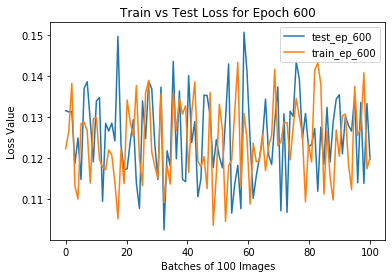

In [66]:
%matplotlib inline
legend = []

epoch = np.linspace(0, 100, num = 100)
chkpt_label = MSE_results[0][0].split('.')[0].split('_')[-1]

test_label = 'test_ep_{}'.format(chkpt_label)
legend.append(test_label)
train_label = 'train_ep_{}'.format(chkpt_label)
legend.append(train_label)

plt.title("Train vs Test Loss for Epoch {}".format(chkpt_label))
plt.plot(epoch, MSE_results[0][1])
plt.plot(epoch, MSE_results[0][2])
plt.xlabel("Batches of 100 Images")
plt.ylabel("Loss Value")

plt.legend(legend)

## Save evaluation results to experiment folder

In [ ]:
eval_file = exp_path + "checkpoint_evaluation.png"

In [ ]:
with open(eval_file, 'w+') as file_object:
    for exp in MSE_results:
        test_loss  = exp[0]
        train_loss = exp[1]
        delta_MSE  = exp[2]
        checkpoint = exp[3]
        line1 = "Checkpoint: {}\n".format(checkpoint)
        line2 = "test_loss: {}, train_loss: {}, delta_MSE: {}".format(test_loss, train_loss, delta_MSE)
        line = line1 + line2 + "\n" # Punctuation with a newline character is a Unix best practice
        file_object.write(line)